<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/chapters_book1/chB_linalg/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear algebra

## TOC:
* [Basics](#basics)
* [Sparse matrices](#sparse)
* [Broadcasting](#broadcasting)
* [Einstein summation](#einstein)
* [Eigenvalue decomposition](#EVD)
* [Singular value decomposition](#SVD)
* [Other decompositions](#decomp)
* [Matrix calculus](#calculus)
* [Linear systems of equations](#linear)


In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows



In [2]:
# https://github.com/google/jax
import jax
import jax.numpy as np
import numpy as onp # original numpy
from jax.scipy.special import logsumexp
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))

jax version 0.2.7


In [3]:
# JAX has a different API for random number generation
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (5,5))
print(x)

# So we make some wrappers so our code works for both JAX and vanilla numpy

def set_seed(seed):
    onp.random.seed(seed)
    
def randn(*args):
    return onp.random.randn(*args)
        
def randperm(args):
    return onp.random.permutation(args)

[[ 2.516 -1.395 -0.863  0.641 -0.378]
 [-0.604  1.907 -0.179 -0.758 -0.516]
 [ 1.267 -0.123 -1.266 -0.173  1.066]
 [ 1.581 -2.028 -0.132 -0.145  0.215]
 [-0.695 -0.931 -0.898 -0.253 -0.349]]


## Basics <a class="anchor" id="basics"></a>

In [4]:
# Create 1d vector
v = np.array([0,1,2]) # 1d vector
print(v.ndim) ## 1
print(v.shape) ## (3,)


1
(3,)


In [5]:
# Note that Python uses 0-indexing, not 1-indexing.
# Thus the elements are accessed as follows:
print(v[0], v[1], v[2]) ## 0 1 2

0 1 2


In [6]:
# Create 2d array
A = np.array([ [0,1,2], [3,4,5] ]) 
print(A)
## [[0, 1, 2],
##  [3, 4, 5]])
print(A.ndim) ## 2
print(A.shape) ## (2,3)
print(A.size) ## 6
print(A.T.shape) ## (3,2)

[[0 1 2]
 [3 4 5]]
2
(2, 3)
6
(3, 2)


In [7]:
# If we want to make a vector into a matrix with one row, we can use any of the following:

x = np.array([1,2]) # vector
X1 = np.array([x]) # matrix with one row
X2 = np.reshape(x, (1,-1))
X3 = x[None, :]
X4 = x[np.newaxis, :]
assert np.array_equal(X1, X2)
assert np.array_equal(X1, X3)
print(np.shape(X1)) ## (1,2)


(1, 2)


In [8]:
# If we want to make a vector into a matrix with one column, we can use any of the following:
x = np.array([1,2]) # vector
X1 = np.array([x]).T # matrix with one column
X2 = np.reshape(x, (-1,1))
X3 = x[:, None]
X4 = x[:, np.newaxis]
assert np.array_equal(X1, X2)
assert np.array_equal(X1, X3)
print(np.shape(X1)) ## (2,1)

(2, 1)


In [9]:
# Here is how to create a one-hot encoding of integers.

def one_hot(x, k, dtype=np.float32):
  return np.array(x[:, None] == np.arange(k), dtype)


# Example
x = np.array([1,2,0,2]);
X = one_hot(x, 3)
print(X)



[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [10]:

# We can construct arrays from a list of column vectors as follows:
A1 = np.array([ [0,1,2], [3,4,5] ]) 
col0 = A1[:,0]; col1 = A1[:,1]; col2=A1[:,2];
A2 = np.stack([col0,col1,col2],axis=1)
assert np.array_equal(A1, A2)

# We can construct arrays from a list of row vectors as follows:
row0=A1[0,:]; row1=A1[1,:];
A2 = np.stack([row0,row1],axis=0)
assert np.array_equal(A1, A2)

In [11]:
# We can construct arrays from a list of arrays
# using the hstack or vstack functions,
# which stack horizontally or vertically,  as illustrated below.

M = np.array([[9,8,7],[6,5,4]])
C = np.array([[99], [99]])
A1 = np.concatenate([M, C], axis=1)
A2 = np.hstack([M, C])
#A3 = np.c_[M, C] # c_ does not work in jax
assert np.array_equal(A1, A2)
#assert np.array_equal(A1, A3)
print(A1)



[[ 9  8  7 99]
 [ 6  5  4 99]]


In [12]:

R = np.array([[1,2,3]])
A1 = np.concatenate([R, M], axis=0)
A2 = np.vstack([R, M])
assert np.array_equal(A1, A2)
print(A1)


[[1 2 3]
 [9 8 7]
 [6 5 4]]


In [13]:
# A very common idiom  is to add a column of 1s to a datamatrix.
# We can do this using horizontal stacking (along the columns) as follows.

X = np.array([[9,8,7],[6,5,4]])
N = np.shape(X)[0] # num. rows
X1 = np.hstack([np.ones((N,1)), X])
print(X1)

[[1. 9. 8. 7.]
 [1. 6. 5. 4.]]


In [14]:

# We can flatten a matrix to a vector (concatenating its rows, one by one) using ravel

A = np.reshape(np.arange(6),(2,3))
print(A.ravel()) ##  [0 1 2 3 4 5]


[0 1 2 3 4 5]


In numpy,  arrays are layed out in memory
such that, if we iterate over neighboring elements,
the rightmost index changes the fastest.
This is called row-major order,
and is used by other languages such as C++, Eigen and PyTorch.
By contrast, other languages (such as Julia, Matlab, R and Fortran)
use column-major order.
See below for an illustration of the difference.


<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Row_and_column_major_order.svg" width="200">


(Source: https://commons.wikimedia.org/wiki/File:Row_and_column_major_order.svg)

Thus in numpy, for speed reasons, we should always write loops like this:
```
A = np.reshape(np.arange(6),(2,3))
d1, d2 = np.shape(A)
for i in range(d1):
  for j in range(d2):
    # Do something with A[i,j]
 ```

For similar reasons, data matrices are usually stored
in the form $(N,D)$, where $N$ is the batchsize (number of examples),
so that we can efficiently extract minibatches by slicing blocks of consecutive memory.

In [15]:
## We can create a tensor in numpy as in this example:

#T = np.ndarray([2,3,4]) # fill with random values # does not work with jax
T = np.zeros((2,3,4))
T = np.reshape(np.arange(24),(2,3,4)) # fill with 0..23
print(np.shape(T))
print(T)



(2, 3, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [16]:
#We can permute the order of the dimensions using np.transpose.

x = np.ones((1, 2, 3))
print(np.transpose(x, (1, 0, 2)).shape) ## (2, 1, 3)

#Note that this does not actually move the data in memory
#(which would be slow),
#it merely provides a different \keywordDef{view} of the same data,
#i.e., it changes the mapping from $n$-dimensional vectors of
#subscripts to 1d integers.

(2, 1, 3)


In [17]:
# matrix multiplication 

A = onp.random.rand(2,3);
B = onp.random.rand(3,4);
C = np.dot(A,B)
assert np.shape(C) == (2,4)
print(C)
C2 = A.dot(B)
C3 = A @ B
assert np.allclose(C, C2)
assert np.allclose(C, C3)

#Note that we need to use np.dot(A,B)
#if we use A * B, Python tries to compute the elementwise product,
#which is invalid, since $A$ and $B$ have incompatible shapes.


[[0.31  0.55  0.287 0.419]
 [0.418 0.621 0.307 0.52 ]]


In [18]:
# Outer products

x = np.arange(1,3); y = np.arange(1,3); 
A = np.outer(x,y);
print(A)


[[1 2]
 [2 4]]


In [19]:
# We can sum across the rows

X = np.reshape(np.arange(6), (2,3))
XS = np.dot(np.ones((1,2)), X)
print(XS)
XS2 = np.sum(X, axis=0)
assert np.allclose(XS, XS2)


[[3. 5. 7.]]


In [20]:
# We can sum across the columns 

X = np.reshape(np.arange(6), (2,3))
XS = np.dot(X, np.ones((3,1)))
print(XS)
XS2 = np.sum(X, axis=1).reshape(-1, 1)
assert np.allclose(XS, XS2)


[[ 3.]
 [12.]]


In [21]:
# We can sum across all entries

X = np.reshape(np.arange(6), (2,3))
S1 = np.dot(np.ones((1,2)), np.dot(X, np.ones((3,1))))[0]
S2 = np.sum(X)
assert np.allclose(S1, S2)


In [22]:
# Kronecker product

np.kron(np.eye(2), np.ones((2,2)))


DeviceArray([[1., 1., 0., 0.],
             [1., 1., 0., 0.],
             [0., 0., 1., 1.],
             [0., 0., 1., 1.]], dtype=float32)

In [23]:
# Vector Norms
x = np.arange(6)
print(np.linalg.norm(x, 2) ** 2)
print(np.sum(np.power(x, 2)))
print(np.linalg.norm(x, np.inf))

# Matrix norms
A = onp.random.randn(4,4)
print(onp.linalg.norm(A, ord=2)) # not supported by jax
print(onp.linalg.norm(A, ord='nuc')) # not supported by jax
print(np.linalg.norm(A, ord='fro'))



54.999996
55
5.0
2.8985264155894463
6.954729906402635
4.0065484


In [24]:
# Size of a matrix

print(np.trace(A))
print(onp.linalg.det(A)) # not supported by jax
print(onp.linalg.cond(A)) # not supported by jax

0.61824524
3.76606451160376
5.924791970356876


## Sparse matrices  <a class="anchor" id="sparse"></a>

In [25]:
from scipy.sparse import diags
A = diags([1,2,3])
print(A)
print(A.toarray())


  (0, 0)	1.0
  (1, 1)	2.0
  (2, 2)	3.0
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]


In [26]:
# Block diagonal

from scipy.linalg import block_diag
block_diag([2, 3], [[4, 5], [6, 7]])



array([[2, 3, 0, 0],
       [0, 0, 4, 5],
       [0, 0, 6, 7]])

Band diagonal

See (https://pypi.org/project/bandmat)

## Broadcasting  <a class="anchor" id="broadcasting"></a>

In numpy, the command A * B computes the elementwise multiplication of arrays or tensors A and B.
If these arrays have different shapes,
they will be automatically converted to have compatible shapes by
implictly replicating  certain dimensions; this is called
**broadcasting**. The following conversion rules are applied
in order:

* If the two arrays differ in their number of dimensions, the
   shape of the one with fewer dimensions is padded with ones on the
   left side. For example, a scalar will be converted to a vector,
   and a vector to a matrix with one row.
* If the shape of the two arrays does not match in any dimension,
   the array with shape equal to 1 in that dimension is stretched to
   match the other shape, by replicating the corresponding contents.
* If in any dimension the sizes disagree and neither is equal to
   1, an error is raised.


<img src="https://github.com/probml/pyprobml/tree/master/notebooks/figures/broadcasting.svg" width="200">
 
Figure made by [broadcasting_fig.py](https://github.com/probml/pyprobml/blob/master/scripts/broadcasting_fig.py) by Jake VanderPlas.


In [27]:
# Example: scaling each column
X = np.reshape(np.arange(6), (2,3))
s = np.array([1,2,3])
XS = X * s 
print(XS)
XS2 = np.dot(X, np.diag(s)) # post-multiply by diagonal
assert np.allclose(XS, XS2)


[[ 0  2  6]
 [ 3  8 15]]


In [28]:
# Example: scaling each row
X = np.reshape(np.arange(6), (2,3))
s  = np.array([1,2])
XS = X *  np.reshape(s, (-1,1)) 
print(XS)
XS2 = np.dot(np.diag(s), X) # pre-multiply by diagonal
assert np.allclose(XS, XS2)

[[ 0  1  2]
 [ 6  8 10]]


## Einstein summation  <a class="anchor" id="broadcasting"></a>

Einstein summation lets us write formula such as  inputs -> outputs, which name the dimensions 
of the input tensor and output tensors; dimensions which are not named in the output are summed over - this is called **tensor contraction**.


In [29]:
# Sample data
a = np.arange(3)
b = np.arange(3)
A = np.arange(6).reshape(2,3)
B = np.arange(15).reshape(3,5)
S = np.arange(9).reshape(3,3)
T = onp.random.randn(2,2,2,2)

Now consider einsum with  a single tensor.

In [30]:


# Matrix transpose
assert np.allclose(A.T, np.einsum('ij->ji', A))

# Sum all elements
assert np.allclose(np.sum(A), np.einsum('ij->', A))

# Sum across rows
assert np.allclose(np.sum(A, axis=0), np.einsum('ij->j', A))

# Sum across columns
assert np.allclose(np.sum(A, axis=1), np.einsum('ij->i', A))

# Sum specific axis of tensor
assert np.allclose(np.sum(T, axis=1), np.einsum('ijkl->ikl', T))
assert np.allclose(np.sum(np.sum(T, axis=0), axis=0), np.einsum('ijkl->kl', T))

# repeated indices with one arg extracts diagonals
assert np.allclose(np.diag(S), np.einsum('ii->i', S))
          
# Trace
assert np.allclose(np.trace(S), np.einsum('ii->', S))


Now consider einsum with 2 tensors.

In [31]:


# Matrix vector multiplication
assert np.allclose(np.dot(A, b), np.einsum('ik,k->i', A, b))

# Matrix matrix multiplication
assert np.allclose(np.dot(A, B), np.einsum('ik,kj->ij', A, B))
assert np.allclose(np.matmul(A, B), np.einsum('ik,kj->ij', A, B))

# Inner product 
assert np.allclose(np.dot(a, b), np.einsum('i,i->', a, b))
assert np.allclose(np.inner(a, b), np.einsum('i,i->', a, b))

# Outer product
assert np.allclose(np.outer(a, b), np.einsum('i,j->ij', a, b))

# Elementwise product
assert np.allclose(a * a, np.einsum('i,i->i', a, a))
assert np.allclose(A * A, np.einsum('ij,ij->ij', A, A))
assert np.allclose(np.multiply(A, A), np.einsum('ij,ij->ij', A, A))


 As a more complex example,
 suppose we have a 3d tensor $S_{ntk}$ where $n$ indexes examples in the
 batch, $t$ indexes locations in the sequence, and $k$ indexes words
 in a one-hot representation.
 Let $W_{kd}$ be an embedding matrix that maps sparse one-hot vectors
 $R^k$  to dense vectors in $R^d$.
 We can convert the batch of sequences of one-hots
 to a batch of sequences of embeddings as follows:
$$
E_{ntd} = \sum_k S_{ntk} W_{kd}
$$
We can compute the sum of the embedding vectors for
each sequence (to get a global representation
of each bag of words) as follows:
$$
E_{nd} = \sum_k \sum_t S_{ntk} W_{kd}
$$
Finally we can pass each sequence's vector representation
through another linear transform $V_{dc}$ to map to the logits over a
classifier
with $c$ labels:
$$
L_{nc} = \sum_d E_{nd} V_{dc}
= \sum_d \sum_k \sum_t S_{ntk} W_{kd} V_{dc}
$$
In einsum notation, we have
$$
L_{nc} = S_{ntk} W_{kd} V_{dc}
$$
We sum  over $k$ and $d$  because those
indices occur twice on the RHS.
We sum over $t$  because that index does not occur
on the LHS.

In [32]:
# sentence embedding example in code

N = 2; C = 3; D = 4; K = 5; T = 6;
S = onp.random.randn(N, T, K)
W = onp.random.randn(K, D)
V = onp.random.randn(D, C)
Lfast = np.einsum('ntk,kd,dc->nc', S, W, V)
# Compare to brute force way of computing L below.
# We can only do elementwise assignment to L in original numpy, not jax
L = onp.zeros((N,C))
for n in range(N):
    for c in range(C):
        s = 0
        for d in range(D):
            for k in range(K):
                for t in range(T):
                    s += S[n,t,k] * W[k,d] * V[d,c]
        L[n,c] = s # does not work in jax
assert np.allclose(L, Lfast)

In [33]:
# Optimization

path = np.einsum_path('ntk,kd,dc->nc', S, W, V, optimize='optimal')[0]
assert np.allclose(L, np.einsum('ntk,kd,dc->nc', S, W, V, optimize=path))


## Eigenvalue decomposition (EVD)<a class="anchor" id="EVD"></a>

In [42]:
onp.random.seed(42)
M = onp.random.randn(4, 4)
A = M  + M.T # ensure symmetric
assert (A == A.T).all() # check symmetric
evals, evecs = np.linalg.eigh(A) # tell JAX matrix is symmetric
#evals, evecs = onp.linalg.eig(A)
print(evals)
print(evecs)

# Sort columns so one with largest evals (absolute value) are first
idx = np.argsort(np.abs(evals))[::-1] # largest first
evecs = evecs[:, idx] # sort columns
evals = evals[idx]
print(evals)
print(evecs)

[-3.806 -2.09   1.016  3.353]
[[-0.277 -0.202  0.824 -0.45 ]
 [-0.246  0.751  0.369  0.489]
 [ 0.68  -0.316  0.427  0.505]
 [ 0.633  0.543  0.045 -0.55 ]]
[-3.806  3.353 -2.09   1.016]
[[-0.277 -0.45  -0.202  0.824]
 [-0.246  0.489  0.751  0.369]
 [ 0.68   0.505 -0.316  0.427]
 [ 0.633 -0.55   0.543  0.045]]


### Example: Diagonalizing a rotation matrix <a class="anchor" id="EVD-rotation"></a>

As an example, let us construct $A$
by combining
a rotation by 45 degrees about the $z$ axis,
a scaling by $\diag(1,2,3)$, followed by another rotation of -45 degrees.
These components can be recovered from $A$ using EVD, as we show below.


In [72]:
a = (45/180) * np.pi
R = np.array(
        [[np.cos(a), -np.sin(a), 0],
          [np.sin(a), np.cos(a), 0],
          [0, 0, 1]])
print(R)

S = np.diag(np.array([1.0, 2.0, 3.0]))
A = np.dot(np.dot(R, S), R.T) # Rotate, scale, then unrotate


evals, evecs = onp.linalg.eig(A)
idx = np.argsort(np.abs(evals)) # smallest first
U = evecs[:, idx] # sort columns
D = np.diag(evals[[idx]])

assert np.allclose(A, np.dot(U, np.dot(D, U.T))) # eigen decomposition
assert np.allclose(np.abs(R), np.abs(U)) # Recover rotation
assert np.allclose(D, S)  # Recover scale



[[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


### Example: checking for positive definitness

A symmetric matrix is positive definite iff all its eigenvalues are positive.


In [73]:
onp.random.seed(42)
M = onp.random.randn(3, 4)
A = np.dot(M, M.T) # ensure A is positive definite

def is_symmetric(A):
  return (A == A.T).all()

def isposdef(A):
  if not is_symmetric(A):
    return False
  evals, evecs = np.linalg.eigh(A)
  return np.all(evals > 0)

print(isposdef(A))

True


### Power method

In [81]:
from numpy.linalg import norm

onp.random.seed(0)

def power_method(A, max_iter=100, tol=1e-5):
    n = np.shape(A)[0]
    u = onp.random.rand(n)
    converged = False
    iter = 0
    while (not converged) and (iter < max_iter):
        old_u = u
        u = np.dot(A, u)
        u = u / norm(u)
        lam = np.dot(u, np.dot(A, u))
        converged = (norm(u - old_u) < tol)
        iter += 1
    return lam, u

X = onp.random.randn(10, 5)
A = np.dot(X.T, X) # psd matrix
lam, u = power_method(A)

evals, evecs = np.linalg.eigh(A)
idx = np.argsort(np.abs(evals))[::-1] # largest first
#evals = evals[[idx]]
evals = np.array([evals[i] for i in idx])
evecs = evecs[:,idx]

tol = 1e-3
assert np.allclose(evecs[:,0], u, tol)

## Singular value decomposition (SVD) <a class="anchor" id="SVD"></a>

In [92]:
onp.random.seed(0)

A = onp.random.randn(10, 5)

U, S, V = np.linalg.svd(A,full_matrices=False)
print("Full=False: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))

U, S, V = np.linalg.svd(A,full_matrices=True)
print("Full=True: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))


Full=False: shape of U (10, 5), S (5,), V (5, 5)
Full=True: shape of U (10, 10), S (5,), V (5, 5)


In [93]:
onp.random.seed(0)

def make_random_low_rank(D, K):
  A = onp.zeros((D, D), dtype=np.float32) # we use onp so we can mutate A in place
  for i in range(K):
    x = onp.random.randn(D)
    A = A + np.outer(x, x)
  return A


A = make_random_low_rank(10, 3)
U, S, V = np.linalg.svd(A,full_matrices=False) 
print(np.sum(S > 1e-5))
print(onp.linalg.matrix_rank(A))


3
3


## Low rank approximation to an image <a class="anchor" id="SVD-image"></a>

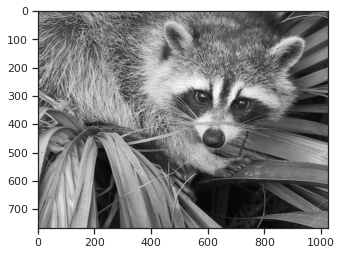

768


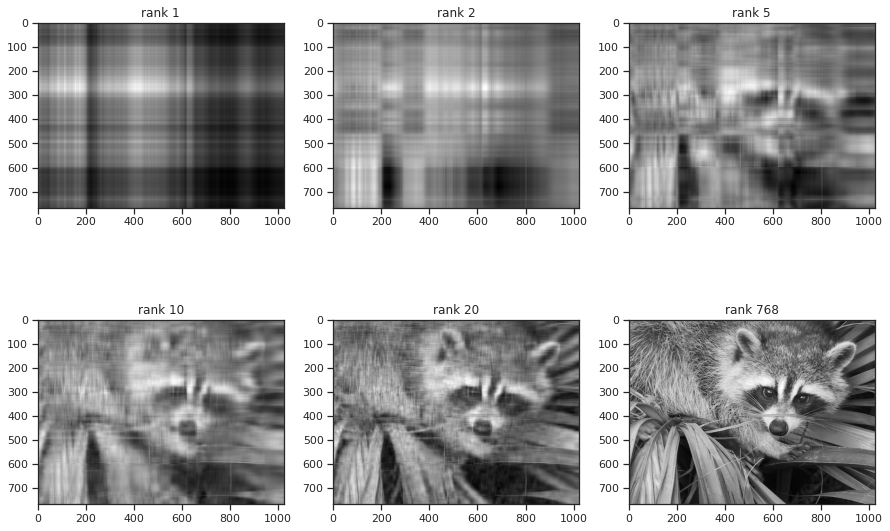

In [94]:
import matplotlib.image

def rgb2gray(rgb):
  #Y' = 0.2989 R + 0.5870 G + 0.1140 B 
  return onp.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#url = 'https://github.com/probml/pyprobml/blob/master/data/clown.png'
#img = matplotlib.image.imread(url) # invalid png file, apparently...
#X = rgb2gray(img)    

import scipy
racoon = scipy.misc.face().astype(onp.float)
X = rgb2gray(racoon)
plt.gray()
plt.imshow(X)
plt.show()

r = onp.linalg.matrix_rank(X)
print(r)

U, sigma, V = np.linalg.svd(X, full_matrices=True)
ranks = [1, 2, 5, 10, 20, r]
R = len(ranks)

fig, axes = plt.subplots(2, 3, figsize=[15, 10])
axes = axes.reshape(-1)
for i in range(R):
    k = ranks[i] 
    x_hat = np.dot(np.dot(U[:, :k], np.diag(sigma[:k])), V[:k, :]) 
    ax = axes[i]
    #plt.subplot(2, 3, i+1)
    ax.imshow(x_hat, cmap='gray')
    ax.set_title("rank {}".format(k))
    #save_fig("svdImageDemoClown{}.pdf".format(k))
plt.show()



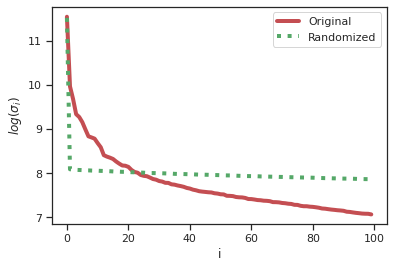

In [95]:
# Plot singular value spectrum
k = 100
plt.figure()
plt.plot(np.log(sigma[:k]), 'r-', linewidth=4, label="Original")
plt.ylabel(r"$log(\sigma_i)$")
plt.xlabel("i")


# Compare this to a random shuffled version of the image
x2 = onp.random.permutation(X)
# so we convert to a 1d vector, permute, and convert back
x1d = X.ravel()
onp.random.shuffle(x1d) # inplace
x2 = x1d.reshape(X.shape)
U, sigma2, V = np.linalg.svd(x2, full_matrices = False)
plt.plot(np.log(sigma2[:k]), 'g:', linewidth=4, label="Randomized")
plt.legend()
#save_fig("svdImageDemoClownSigmaScrambled.pdf")
plt.show()

## Other matrix decompositions <a class="anchor" id="decomp"></a>

In this section, we illustrate a few other matrix decompositions.

### LU decomposition <a class="anchor" id="decomp-LU"></a>

In [96]:

onp.random.seed(42)
A = onp.random.randn(5,5)
L, U = scipy.linalg.lu(A, True)
print(L)
print(U)

[[ 0.339 -0.04   0.733  1.     0.   ]
 [-0.16   1.     0.     0.     0.   ]
 [-0.316 -0.348  0.597 -0.423  1.   ]
 [-0.384 -0.712  1.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[ 1.466 -0.226  0.068 -1.425 -0.544]
 [ 0.     1.543  0.778 -0.697  0.456]
 [ 0.     0.     0.895 -1.951 -1.297]
 [ 0.     0.     0.     3.409  0.919]
 [ 0.     0.     0.     0.    -0.576]]


### QR decomposition <a class="anchor" id="decomp-QR"></a>



In [97]:
# Economy vs full mode

onp.random.seed(42)
A = onp.random.randn(5,3)
Q, R = scipy.linalg.qr(A, mode='economic')
print("economy: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)


Q, R = scipy.linalg.qr(A, mode='full')
print("full: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)
assert np.allclose(np.eye(5), np.dot(Q, Q.T), atol=1e-3)

economy: Q shape (5, 3), R shape (3, 3)
[[-0.213 -0.068  0.765]
 [-0.655 -0.119  0.303]
 [-0.679  0.35  -0.49 ]
 [-0.233 -0.221  0.004]
 [-0.104 -0.9   -0.29 ]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]]
full: Q shape (5, 5), R shape (5, 3)
[[-0.213 -0.068  0.765 -0.018  0.604]
 [-0.655 -0.119  0.303 -0.248 -0.635]
 [-0.679  0.35  -0.49  -0.046  0.418]
 [-0.233 -0.221  0.004  0.943 -0.085]
 [-0.104 -0.9   -0.29  -0.215  0.222]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]


### Cholesky decomposition <a class="anchor" id="decomp-chol"></a>

In [98]:
# Sample from multivariate Gaussian

from scipy.stats import multivariate_normal as mvn

def sample_mvn(mu, Sigma, N):
    L = np.linalg.cholesky(Sigma)
    D = len(mu)
    Z = onp.random.randn(N, D)
    X = np.dot(Z, L.T) + np.reshape(mu, (-1,D))
    return X

D = 5
onp.random.seed(42)
mu = onp.random.randn(D)
A = onp.random.randn(D,D)
Sigma = np.dot(A, A.T)
N = 10000
X = sample_mvn(mu, Sigma, N)
mu_hat = np.mean(X)
C = onp.cov(X, rowvar=False) # not yet implemented by jax
print(C)
print(Sigma)
assert np.allclose(C, Sigma, 1e-0) # not that close, even after 10k samples...

dist = mvn(mu, Sigma)
X = dist.rvs(size=N)
C = onp.cov(X, rowvar=False)
assert np.allclose(C, Sigma, 1e-0)
    

[[ 3.762 -0.445 -1.572 -0.246 -1.439]
 [-0.445  7.072  4.914  3.109  2.191]
 [-1.572  4.914  4.203  1.467  2.151]
 [-0.246  3.109  1.467  4.522  1.431]
 [-1.439  2.191  2.151  1.431  1.896]]
[[ 3.652 -0.479 -1.567 -0.274 -1.432]
 [-0.479  7.126  4.982  3.107  2.228]
 [-1.567  4.982  4.26   1.488  2.179]
 [-0.274  3.107  1.488  4.53   1.462]
 [-1.432  2.228  2.179  1.462  1.924]]


## Matrix calculus <a class="anchor" id="calculus"></a>

### Automatic differentiation in Jax  <a class="anchor" id="AD-jax"></a>

In this section, we show how to use Jax to compute gradients, Jacobians and Hessians
of some simple functions.

In [99]:
from jax import grad, hessian, jacfwd, jacrev, vmap, jit

In [100]:
# We construct a single output linear function.
# In this case, the Jacobian and gradient are the same.
Din = 3; Dout = 1;
onp.random.seed(42)
A = onp.random.randn(Dout, Din)
def fun1d(x):
    return np.dot(A, x)[0]
x = onp.random.randn(Din)
g = grad(fun1d)(x)
J = jacrev(fun1d)(x)
assert np.allclose(J, g)

In [101]:
# We construct a multi-output linear function.
# We check forward and reverse mode give same Jacobians.
Din = 3; Dout = 4;
A = onp.random.randn(Dout, Din)
def fun(x):
    return np.dot(A, x)
x = onp.random.randn(Din)
Jf = jacfwd(fun)(x)
Jr = jacrev(fun)(x)
assert np.allclose(Jf, Jr)
assert np.allclose(Jf, A)

In [102]:
# Hessian of a quadratic form
D = 4
A = onp.random.randn(D, D)
x = onp.random.randn(D)
quadfun = lambda x: np.dot(x, np.dot(A, x))
H1 = hessian(quadfun)(x)
assert np.allclose(H1, A+A.T)

def my_hessian(fun):
  return jacfwd(jacrev(fun))

H2 = my_hessian(quadfun)(x)
assert np.allclose(H1, H2)

### Worked example: logistic regression  <a class="anchor" id="AD-jax-logreg"></a>

In this section, we compute the gradients and Hessian of the NLL  for binary logistic regression using Jax, and compare to the analytical formula. We then solve for the MLE using a (batch) optimizer, and compare to sklearn. Since the objective is convex, we should get exactly the same answer.

In [103]:
# First we create a dataset.

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"]
y = (iris["target"] == 2).astype(onp.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4


X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

In [104]:
# Now let's find the MLE using sklearn. We will use this as the "gold standard"

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)


[-4.414 -9.111  6.539 12.686]


In [105]:
# Now we try to fit the model ourselves.
# First we define the model, and check it gives the same output as sklearn.

def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return np.dot(inputs, weights) # Already vectorized

def predict_prob(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

ptest_sklearn = log_reg.predict_proba(X_test)[:,1]
print(np.round(ptest_sklearn, 3))

ptest_us = predict_prob(w_mle_sklearn, X_test)
print(np.round(ptest_us, 3))

assert np.allclose(ptest_sklearn, ptest_us, atol=1e-2)

[0.002 0.    1.    0.012 0.002 0.    0.    0.979 0.74  0.    0.706 0.
 0.    0.    0.    0.001 1.    0.    0.009 1.    0.    0.65  0.    1.
 0.094 0.998 1.    1.    0.    0.    0.    0.    0.    0.    0.    0.998
 0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.281 0.909
 0.    0.999]
[0.002 0.    1.    0.012 0.002 0.    0.    0.979 0.74  0.    0.706 0.
 0.    0.    0.    0.001 1.    0.    0.009 1.    0.    0.65  0.    1.
 0.094 0.998 1.    1.    0.    0.    0.    0.    0.    0.    0.    0.998
 0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.281 0.909
 0.    0.999]


In [106]:
# Next we define the objective and check it gives the same output as sklearn.

from sklearn.metrics import log_loss
from jax.scipy.special import logsumexp
#from scipy.misc import logsumexp

def NLL_unstable(weights, batch):
    inputs, targets = batch
    p1 = predict_prob(weights, inputs)
    logprobs = np.log(p1) * targets + np.log(1 - p1) * (1 - targets)
    N = inputs.shape[0]
    return -np.sum(logprobs)/N


def NLL(weights, batch):
    # Use log-sum-exp trick
    inputs, targets = batch
    # p1 = 1/(1+exp(-logit)), p0 = 1/(1+exp(+logit))
    logits = predict_logit(weights, inputs).reshape((-1,1))
    N = logits.shape[0]
    logits_plus = np.hstack([np.zeros((N,1)), logits]) # e^0=1
    logits_minus = np.hstack([np.zeros((N,1)), -logits])
    logp1 = -logsumexp(logits_minus, axis=1)
    logp0 = -logsumexp(logits_plus, axis=1)
    logprobs = logp1 * targets + logp0 * (1-targets)
    return -np.sum(logprobs)/N

# We can use a small amount of L2 regularization, for numerical stability
def PNLL(weights, batch, l2_penalty=1e-5):
    nll = NLL(weights, batch)
    l2_norm = np.sum(np.power(weights, 2)) # squared L2 norm
    return nll + l2_penalty*l2_norm

# We evaluate the training loss at the MLE, where the parameter values are "extreme".
nll_train = log_loss(y_train, predict_prob(w_mle_sklearn, X_train))
nll_train2 = NLL(w_mle_sklearn, (X_train, y_train))
nll_train3 = NLL_unstable(w_mle_sklearn, (X_train, y_train))
print(nll_train)
print(nll_train2)
print(nll_train3)

# We also evaluate on the test set.
nll_test = log_loss(y_test, predict_prob(w_mle_sklearn, X_test))
nll_test2 = NLL(w_mle_sklearn, (X_test, y_test))
nll_test3 = NLL_unstable(w_mle_sklearn, (X_test, y_test))
print(nll_test)
print(nll_test2)
print(nll_test3)
    


0.06907698269738603
0.06907697
nan
0.11824004126070634
0.11824003
nan


In [107]:
# Next we check the gradients compared to the manual formulas.
# For simplicity, we initially just do this for a single random example.

onp.random.seed(42)
D = 5
w = onp.random.randn(D)
x = onp.random.randn(D)
y = 0 

#d/da sigmoid(a) = s(a) * (1-s(a))
deriv_sigmoid = lambda a: sigmoid(a) * (1-sigmoid(a))
deriv_sigmoid_jax = grad(sigmoid)
a = 1.5 # a random logit
assert np.isclose(deriv_sigmoid(a), deriv_sigmoid_jax(a))

# mu(w)=s(w'x), d/dw mu(w) = mu * (1-mu) .* x
def mu(w): return sigmoid(np.dot(w,x))
def deriv_mu(w): return mu(w) * (1-mu(w)) * x
deriv_mu_jax =  grad(mu)
assert np.allclose(deriv_mu(w), deriv_mu_jax(w))

# NLL(w) = -[y*log(mu) + (1-y)*log(1-mu)]
# d/dw NLL(w) = (mu-y)*x
def nll(w): return -(y*np.log(mu(w)) + (1-y)*np.log(1-mu(w)))
def deriv_nll(w): return (mu(w)-y)*x
deriv_nll_jax = grad(nll)
assert np.allclose(deriv_nll(w), deriv_nll_jax(w))



In [108]:
# Now let's check the batch version using our dataset.

N = X_train.shape[0]
mu = predict_prob(w_mle_sklearn, X_train)

g1 = grad(NLL)(w_mle_sklearn, (X_train, y_train))
g2 = np.sum(np.dot(np.diag(mu - y_train), X_train), axis=0)/N
print(g1)
print(g2)
assert np.allclose(g1, g2, atol=1e-2)

H1 = hessian(NLL)(w_mle_sklearn, (X_train, y_train))
S = np.diag(mu * (1-mu))
H2 = np.dot(np.dot(X_train.T, S), X_train)/N
print(H1)
print(H2)
assert np.allclose(H1, H2, atol=1e-2)


[ 5.588e-08  7.041e-07 -9.853e-07 -1.429e-06]
[ 5.960e-08  7.176e-07 -9.871e-07 -1.428e-06]
[[0.802 0.366 0.644 0.213]
 [0.366 0.168 0.294 0.098]
 [0.644 0.294 0.519 0.171]
 [0.213 0.098 0.171 0.057]]
[[0.802 0.366 0.644 0.213]
 [0.366 0.168 0.294 0.098]
 [0.644 0.294 0.519 0.171]
 [0.213 0.098 0.171 0.057]]


In [109]:
# Finally, use BFGS batch optimizer to compute MLE, and compare to sklearn

import scipy.optimize

def training_loss(w):
    return NLL(w, (X_train, y_train))

def training_grad(w):
    return grad(training_loss)(w)

onp.random.seed(43)
N, D = X_train.shape 
w_init = onp.random.randn(D)
w_mle_scipy = scipy.optimize.minimize(training_loss, w_init, jac=training_grad, method='BFGS').x
prob_scipy = predict_prob(w_mle_scipy, X_test)
prob_sklearn = predict_prob(w_mle_sklearn, X_test)
print(np.round(prob_scipy, 3))
print(np.round(prob_sklearn, 3))

assert np.allclose(prob_scipy, prob_sklearn, atol=1e-2)

[0.002 0.    1.    0.012 0.002 0.    0.    0.979 0.74  0.    0.706 0.
 0.    0.    0.    0.001 1.    0.    0.009 1.    0.    0.65  0.    1.
 0.094 0.998 1.    1.    0.    0.    0.    0.    0.    0.    0.    0.998
 0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.281 0.909
 0.    0.999]
[0.002 0.    1.    0.012 0.002 0.    0.    0.979 0.74  0.    0.706 0.
 0.    0.    0.    0.001 1.    0.    0.009 1.    0.    0.65  0.    1.
 0.094 0.998 1.    1.    0.    0.    0.    0.    0.    0.    0.    0.998
 0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.281 0.909
 0.    0.999]


## Solving linear systems of equations <a class="anchor" id="linear"></a>

### Square systems with unique solution <a class="anchor" id="linear-systems-square"></a>

In [110]:
A = np.array([[3,2,-1], [2, -2, 4], [-1, 0.5, -1]])
b = np.array([1, -2, 0])
x  = jax.scipy.linalg.solve(A,b)
print(x)
print(np.dot(A, x) - b)

[ 1. -2. -2.]
[ 0.000e+00 -4.768e-07  0.000e+00]


In [111]:
# Now use LU decomposition and backsubstitution.

L, U = jax.scipy.linalg.lu(A, permute_l=True)
print(L)
print(U)
y = jax.scipy.linalg.solve_triangular(L, b, lower=True)
x = jax.scipy.linalg.solve_triangular(U, y, lower=False)
print(x)

[[ 1.     0.     0.   ]
 [ 0.667  1.     0.   ]
 [-0.333 -0.35   1.   ]]
[[ 3.     2.    -1.   ]
 [ 0.    -3.333  4.667]
 [ 0.     0.     0.3  ]]
[ 1. -2. -2.]


### Underconstrained systems: least norm solution <a class="anchor" id="linear-systems-under"></a>

We will compute the minimum norm solution.

In [112]:
onp.random.seed(42)
m = 3
n = 4
A = onp.random.randn(m, n)
x = onp.random.randn(n)
b = np.dot(A, x)

#x_least_norm = jax.scipy.linalg.lstsq(A, b)[0]
x_least_norm = scipy.linalg.lstsq(A, b)[0]
print(x_least_norm)
print(np.dot(A, x_least_norm) - b)
print(np.linalg.norm(x_least_norm, 2))


[ 1.162 -1.083 -1.26  -0.985]
[ 0.000e+00  0.000e+00 -1.192e-07]
2.2538505


If you look at the [source code for scipy.linalg.lstsq](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058),
you will see that it just a Python wrapper
to some LAPACK code written in Fortran. LAPACK offers multiple methods for solving
linear systems, including `gelsd` (default), `gelss` , and `gelsy`. The first two methods use SVD, the latter uses QR decomposition. 

A lot of numpy and scipy functions are just wrappers to legacy libraries,
  written in Fortran or C++, since Python itself is too slow for
  efficient numerical computing.
  Confusingly, sometimes numpy and scipy offer different wrappers to the same
  underlying LAPACK functions, but with different interfaces.
  For example, as of 2018, `np.linalg.lstsq` and
  `scipy.linalg.lstsq` have been modified to behave the same.
  However,
  `np.linalg.qr` and `scipy.linalg.qr`
  have slightly different optional arguments and may give different
  results.
  
Jax does not yet implement lstsq, but does implement some of the underlying methods 
 [here](https://github.com/google/jax/blob/master/jax/scipy/linalg.py).
 Unlike the legacy code, this can run fast on GPUs and TPUs.

### Overconstrained systems: least squares solution <a class="anchor" id="linear-systems-over"></a>

In [115]:
def naive_solve(A, b):
    return jax.numpy.linalg.inv(A.T @ A) @ A.T @ b
    #return jnp.linalg.inv(A.T @ A) @ A.T @ b

def qr_solve(A, b):
    Q, R = np.linalg.qr(A) 
    Qb = np.dot(Q.T,b) 
    return jax.scipy.linalg.solve_triangular(R, Qb)

def lstsq_solve(A, b):
    return scipy.linalg.lstsq(A, b, rcond=None)[0]

def pinv_solve(A, b):
    return np.dot(np.linalg.pinv(A), b)
    
onp.random.seed(42)
m = 4
n = 3
A = onp.random.randn(m, n)
x = onp.random.randn(n)
b = np.dot(A, x)


methods = list()
solns = list()
    
methods.append('naive')
solns.append(naive_solve(A, b))

#methods.append('pinv')
#solns.append(pinv_solve(A,b)) # pinv not yet implemented by jax

#methods.append('lstsq')
#solns.append(lstsq_solve(A, b)) # lstsq not yet implemented by jax

methods.append('qr')
solns.append(qr_solve(A, b))


for (method, soln) in zip(methods, solns):
    residual = b -  np.dot(A, soln)
    print('method {}, norm {:0.5f}, residual {:0.5f}'.format(method, np.linalg.norm(soln), np.linalg.norm(residual)))
    print(soln.T)
    print('\n')

method naive, norm 2.58738, residual 0.00000
[ 0.242 -1.913 -1.725]


method qr, norm 2.58738, residual 0.00000
[ 0.242 -1.913 -1.725]


